##### $\hspace{15pt}$ **Filename: autoML.ipynb**
##### $\hspace{1.5pt}$ **Date Created: October 17, 2023**
##### **Date Modified: December 6, 2023**
##### $\rule{10.5in}{1pt}$
##### **Train and test predictive models on the [heart disease prediction dataset](https://www.kaggle.com/datasets/moazeldsokyx/heart-disease) from Kaggle using the following AutoML libraries:**
* **[auto-sklearn](https://automl.github.io/auto-sklearn/master/index.html#)**
* **[H2O AutoML](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)**
* **[PyCaret](https://pycaret.org/)**
* **[TPOT](https://epistasislab.github.io/tpot/)**

##### **Restart the runtime after installing the packages and before running the remaining cells of the notebook.**

##### $\rule{10.5in}{1pt}$

##### Install auto-sklearn. The installation in Colab does not work when running `!pip install auto-sklearn`. A sequence of steps that does work is available from this [GitHub issue](https://github.com/automl/auto-sklearn/issues/1684).

In [ ]:
!pip install Cython==0.29.36 -q
!pip uninstall scipy -q -y
!pip install scipy==1.9 -q
!pip uninstall pyparsing -q -y
!pip install pyparsing==2.4 -q
!pip uninstall scikit_learn -q -y
!pip uninstall imbalanced-learn -q -y
!pip uninstall mlxtend -q -y
!pip uninstall yellowbrick -q -y
!pip install scikit-learn==0.24.2 --no-build-isolation -q
!pip install auto-sklearn -q

##### Install dython.

In [ ]:
!pip install dython

##### Install H2O.

In [ ]:
!apt-get install default-jre
!java -version
!pip install h2o -q

##### Install PyCaret.

In [ ]:
!pip install pycaret[full] -q

##### Install TPOT.

In [ ]:
!pip install tpot

##### Update seaborn.

In [ ]:
!pip install -U seaborn -q

##### Restart the runtime, and load modules and packages.

In [ ]:
from dython.nominal import associations
from google.colab import drive
from pycaret.classification import *
from sklearn import metrics
from sklearn.inspection import permutation_importance
from tpot import TPOTClassifier
import autosklearn.classification
import autosklearn.ensembles
import h2o
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

##### Set pandas dataframes to display all the columns.

In [ ]:
pd.set_option("display.max_columns", None)

##### Set the float format of pandas dataframes.

In [ ]:
pd.options.display.float_format = "{:.4f}".format

##### Mount Google Drive to Colab.

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##### Load the train and test sets from Google Drive.

In [ ]:
path = "gdrive/MyDrive/Colab Notebooks/4_autoML/"
trainSet = pd.read_csv(path + "train.csv")
trainSet.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0000,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1000,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6000,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0000,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9000,1,3,2,0


In [ ]:
testSet = pd.read_csv(path + "test.csv")
testSet.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5000,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4000,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8000,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6000,2,0,2,1


##### Check if there are missing values.

In [ ]:
trainSet.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [ ]:
testSet.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

##### Visualize the continuous features in the train set.

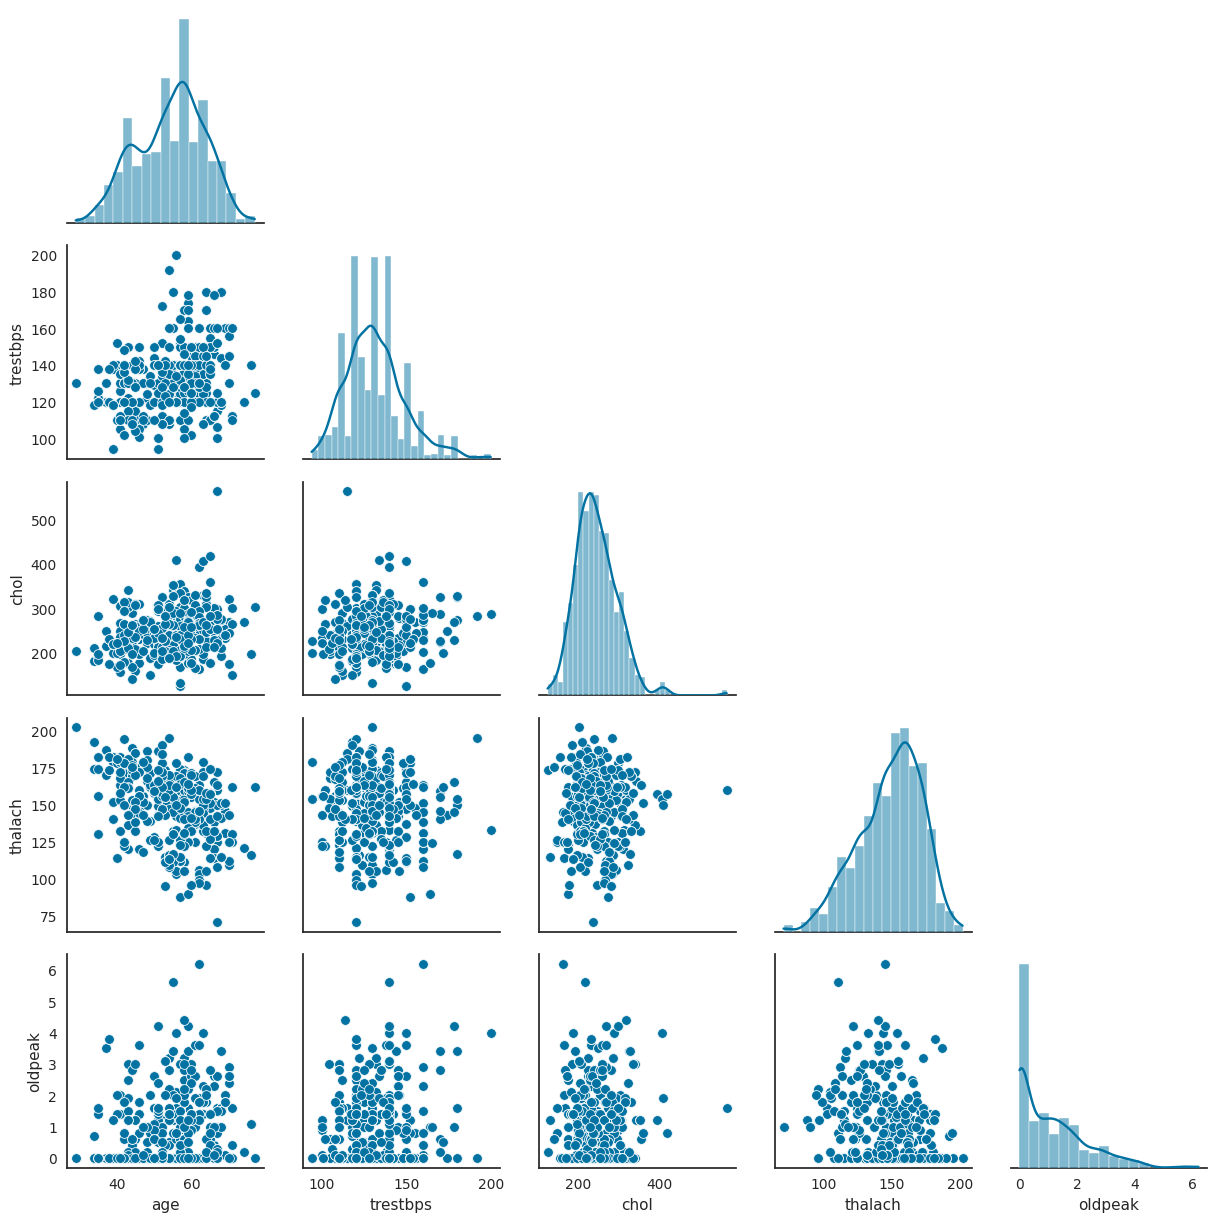

In [ ]:
sns.set_style("white")
grid = sns.PairGrid(trainSet, vars = ["age", "trestbps", "chol", "thalach", "oldpeak"], corner = True, diag_sharey = False)
grid.map_diag(sns.histplot, stat = "percent", kde = True)
grid.map_lower(sns.scatterplot)
plt.show()

##### Visualize the categorical features in the train set.

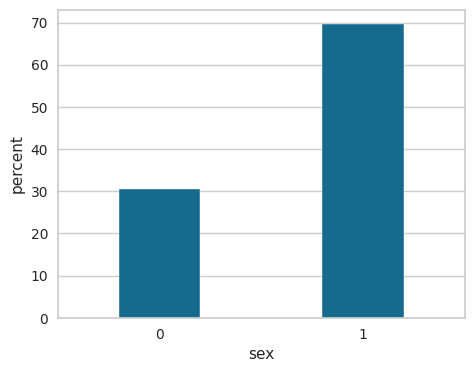

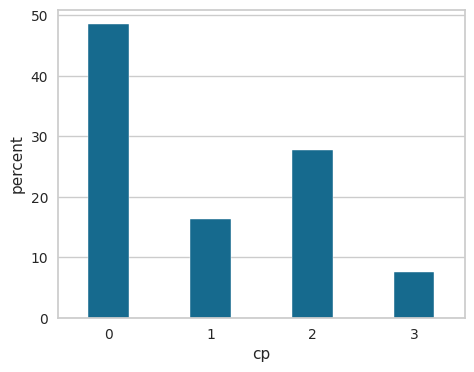

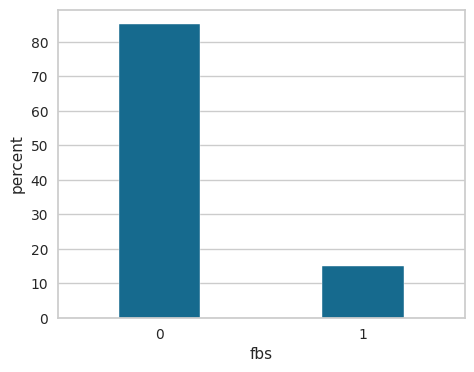

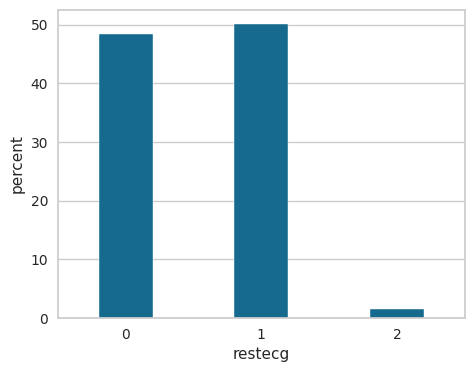

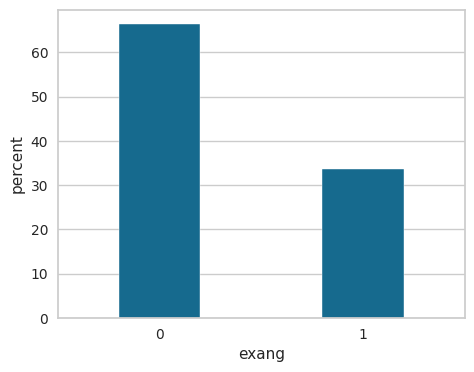

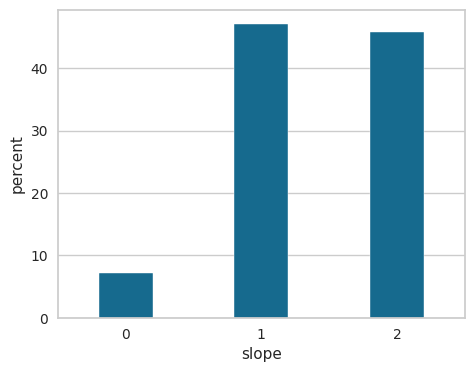

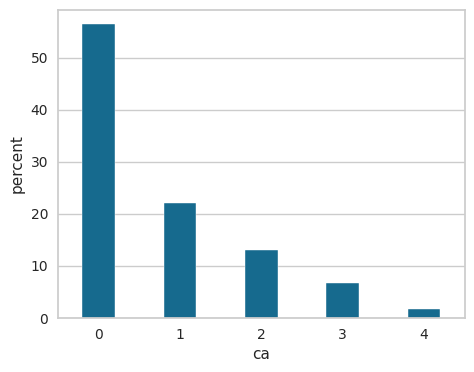

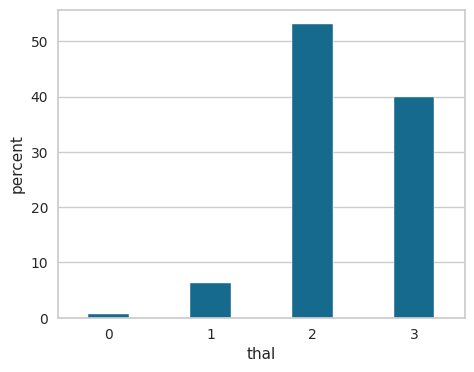

In [ ]:
plt.rcParams["figure.figsize"] = [5.25, 4]
sns.set_style("whitegrid")

categoricalFeatures = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

for feature in categoricalFeatures:

    uniqueValues = trainSet[feature].unique().tolist()
    uniqueValues.sort()
    sns.countplot(data = trainSet, x = feature, order = uniqueValues, stat = "percent", width = 0.4)
    plt.show()

##### Visualize the target in the train set.

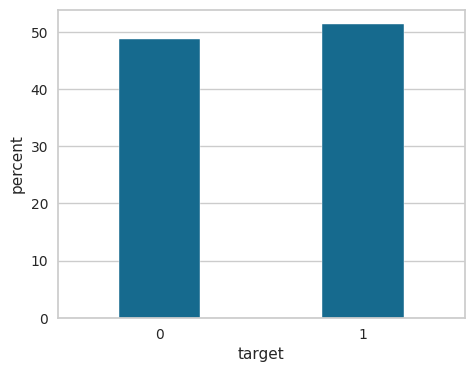

In [ ]:
uniqueValues = trainSet["target"].unique().tolist()
uniqueValues.sort()
sns.countplot(data = trainSet, x = "target", order = uniqueValues, stat = "percent", width = 0.4)
plt.show()

##### Create a correlation heatmap using the variables in the train set.

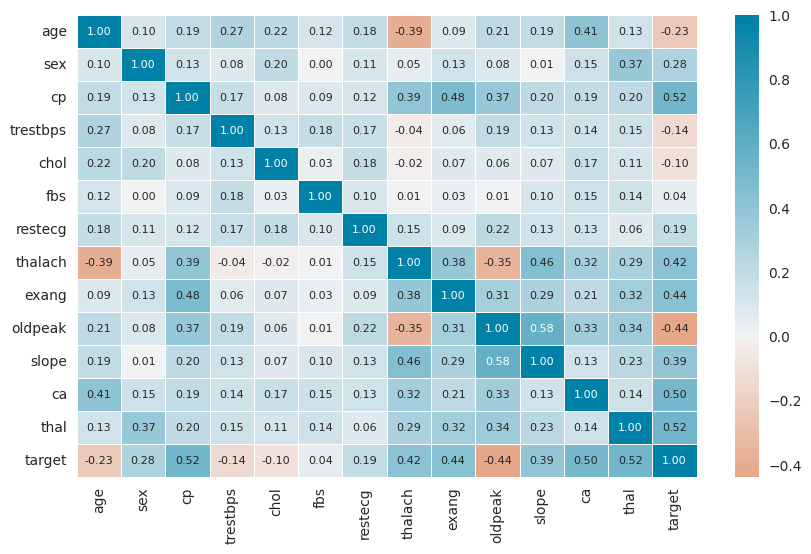

In [ ]:
plt.figure(figsize = (10, 6))
correlationMatrix = associations(trainSet, nominal_columns = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"],
                                 compute_only = True)["corr"]
cmap = sns.diverging_palette(20, 230, s = 100, as_cmap = True)
sns.heatmap(correlationMatrix, cmap = cmap, center = 0, annot = True, annot_kws = {"fontsize": 8}, fmt = ".2f", linewidths = 0.5)
plt.show()

$\hspace{1in}$

<a name="0"></a>
The following list contains links to the sections of this notebook that demonstrate an implementation of the AutoML libraries using the loaded train and test sets.
* **[auto-sklearn](#1)**
* **[H2O AutoML](#2)**
* **[PyCaret](#3)**
* **[TPOT](#4)**

$\hspace{1in}$

<a name="1"></a>
##### **auto-sklearn**

##### Rearrange the columns in the train and test sets so that the numerical features are adjacent and the categorical features are also adjacent.

In [ ]:
numericalFeatures = ["age", "trestbps", "chol", "thalach", "oldpeak", "slope", "ca"]
categoricalFeatures = ["sex", "cp", "fbs", "restecg", "exang", "thal"]

rearrangedTrainSet = trainSet[numericalFeatures + categoricalFeatures + ["target"]]
rearrangedTestSet = testSet[numericalFeatures + categoricalFeatures + ["target"]]

##### Note: The features *slope* and *ca* will be treated as ordinal and will consequently be included among the numerical features.

##### Create models, fit them to the training set, and choose the best model.

In [ ]:
autoSklearnModels = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = 900, ensemble_class = autosklearn.ensembles.SingleBest,
                                                                     memory_limit = 10000, resampling_strategy = "cv",
                                                                     resampling_strategy_arguments = {"folds": 10})

xTrain = rearrangedTrainSet.drop(columns = ["target"])
yTrain = rearrangedTrainSet[["target"]]
featuresType = ["Numerical"]*len(numericalFeatures) + ["Categorical"]*len(categoricalFeatures)
autoSklearnModels.fit(X = xTrain.to_numpy(), y = yTrain.to_numpy(), feat_type = featuresType, dataset_name = "trainSet")

[WARNING] [2023-12-06 07:08:36,057:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2023-12-06 07:09:00,062:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2023-12-06 07:10:09,153:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.singlebest_ensemble.SingleBest'>,
                      memory_limit=10000, per_run_time_limit=90,
                      resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      time_left_for_this_task=900)

##### Display statistics of the training of models.

In [ ]:
print(autoSklearnModels.sprint_statistics())

auto-sklearn results:
  Dataset name: trainSet
  Metric: accuracy
  Best validation score: 1.000000
  Number of target algorithm runs: 27
  Number of successful target algorithm runs: 19
  Number of crashed target algorithm runs: 4
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 0



##### Display all the models trained during the search process.

In [ ]:
trainedModels = autoSklearnModels.leaderboard(ensemble_only = False)
trainedModels.sort_values(by = ['rank'], inplace = True)
trainedModels

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,1.0000,random_forest,0.0000,19.2689
19,2,0.0000,extra_trees,0.0000,20.0540
17,3,0.0000,mlp,0.0000,45.9654
26,4,0.0000,mlp,0.0000,38.3289
27,5,0.0000,mlp,0.0000,20.7295
7,6,0.0000,mlp,0.0000,67.2916
10,7,0.0000,adaboost,0.0010,24.0764
18,8,0.0000,extra_trees,0.0039,67.6580
15,9,0.0000,random_forest,0.0429,26.9178


##### Display the best model.

In [ ]:
autoSklearnModels.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,1.0000,random_forest,0.0000,19.2689


In [ ]:
autoSklearnModels.show_models()

{2: {'model_id': 2,
  'rank': 1,
  'cost': 0.0,
  'ensemble_weight': 1.0,
  'voting_model': VotingClassifier(estimators=None, voting='soft'),
  'estimators': [{'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7e751765b280>,
    'balancing': Balancing(random_state=1),
    'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7e74735d8c40>,
    'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7e74735dac80>,
    'sklearn_classifier': RandomForestClassifier(max_features=4, n_estimators=512, n_jobs=1,
                           random_state=1, warm_start=True)},
   {'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7e746e900d60>,
    'balancing': Balancing(random_state=1),
    'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7e746e773f40>,


##### Predict on test set.

In [ ]:
xTest = rearrangedTestSet.drop(columns = ["target"])
predictionLabels = autoSklearnModels.predict(xTest.to_numpy())
predictionScores = autoSklearnModels.predict_proba(xTest.to_numpy())[:, 1]

testSetPredictions = xTest.copy()
testSetPredictions["prediction_label"] = predictionLabels
testSetPredictions["prediction_score"] = predictionScores
testSetPredictions.head()

,age,trestbps,chol,thalach,oldpeak,slope,ca,sex,cp,fbs,restecg,exang,thal,prediction_label,prediction_score
0,63,145,233,150,2.3000,0,0,1,3,1,0,0,1,1,0.9754
1,37,130,250,187,3.5000,0,0,1,2,0,1,0,2,1,0.9676
2,41,130,204,172,1.4000,2,0,0,1,0,0,0,2,1,0.9973
3,56,120,236,178,0.8000,2,0,1,1,0,1,0,2,1,0.9949
4,57,120,354,163,0.6000,2,0,0,0,0,1,1,2,1,0.9738


##### Plot confusion matrix.

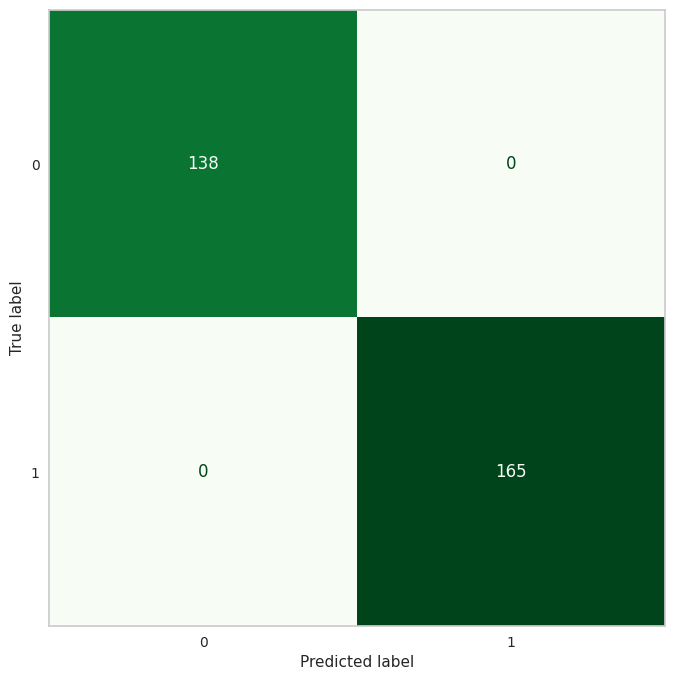

In [ ]:
yTest = rearrangedTestSet["target"]
yPred = testSetPredictions["prediction_label"]
confusionMatrix = metrics.confusion_matrix(yTest, yPred)

plt.rcParams["figure.figsize"] = [12, 8]
display = metrics.ConfusionMatrixDisplay(confusionMatrix)
display.plot(cmap = plt.cm.Greens, colorbar = False)
plt.grid(None)
plt.show()

##### Plot ROC curve.

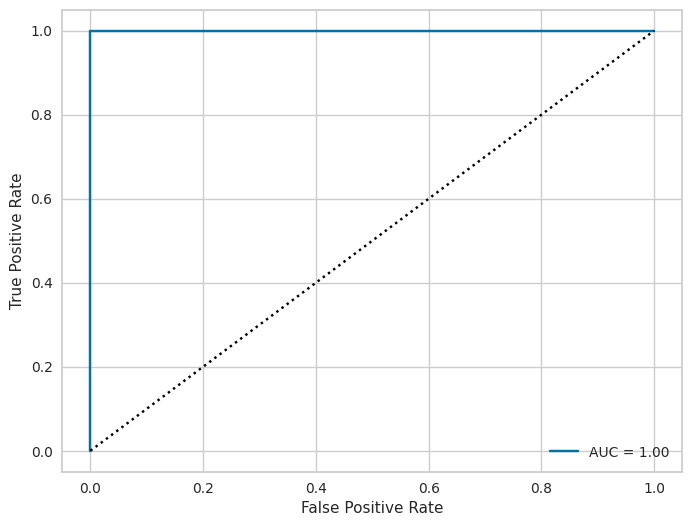

In [ ]:
plt.rcParams["figure.figsize"] = [8, 6]
fpr, tpr, thresholds = metrics.roc_curve(yTest, predictionScores)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
display.plot()
plt.plot([0, 1], [0, 1], linestyle = "dotted", color = "black")
plt.show()

##### Plot permutation importance of the features.

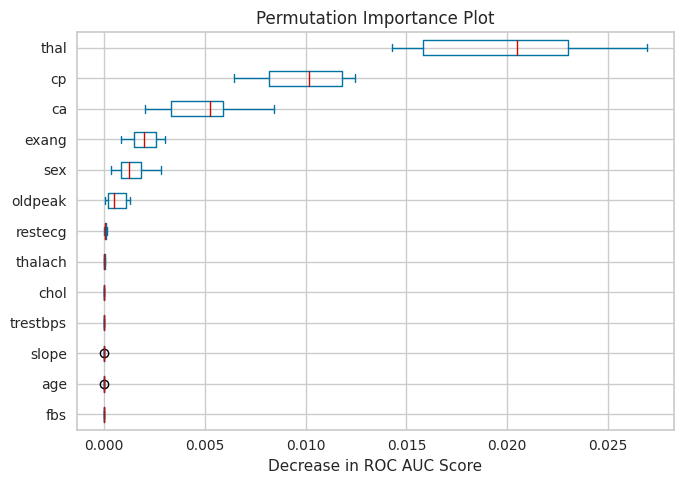

In [ ]:
result = permutation_importance(autoSklearnModels, xTest, yTest, n_repeats = 10, random_state = 1, scoring = "roc_auc")
sortedIdx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sortedIdx].T, columns = xTest.columns[sortedIdx])

plt.rcParams["figure.figsize"] = [7, 5]
ax = importances.plot.box(vert = False)
ax.set_title("Permutation Importance Plot")
ax.set_xlabel("Decrease in ROC AUC Score")
ax.figure.tight_layout()

##### Save best model.

In [ ]:
pickle.dump(autoSklearnModels, open(path + "autoSklearnBestModel.pkl", "wb"))

##### Load best model.

In [ ]:
loadedAutoSklearnBestModel = pickle.load(open(path + "autoSklearnBestModel.pkl", "rb"))

Back to the list of [**section links**](#0)

$\hspace{1in}$

<a name="2"></a>
##### **H2O AutoML**

##### Start the H2O cluster.

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwuwipnkw
  JVM stdout: /tmp/tmpwuwipnkw/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwuwipnkw/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_sh9sxs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


##### Convert each of the train and test sets to an H2OFrame.

In [ ]:
h2oTrainSet = h2o.H2OFrame(trainSet)
h2oTestSet = h2o.H2OFrame(testSet)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


##### Check the data types of the variables in the train and test sets.

In [ ]:
h2oTrainSet.types

{'age': 'int',
 'sex': 'int',
 'cp': 'int',
 'trestbps': 'int',
 'chol': 'int',
 'fbs': 'int',
 'restecg': 'int',
 'thalach': 'int',
 'exang': 'int',
 'oldpeak': 'real',
 'slope': 'int',
 'ca': 'int',
 'thal': 'int',
 'target': 'int'}

In [ ]:
h2oTestSet.types

{'age': 'int',
 'sex': 'int',
 'cp': 'int',
 'trestbps': 'int',
 'chol': 'int',
 'fbs': 'int',
 'restecg': 'int',
 'thalach': 'int',
 'exang': 'int',
 'oldpeak': 'real',
 'slope': 'int',
 'ca': 'int',
 'thal': 'int',
 'target': 'int'}

##### Convert each categorical variable to a factor.

In [ ]:
categoricalVariables = ["sex", "cp", "fbs", "restecg", "exang", "thal", "target"]

h2oTrainSet[categoricalVariables] = h2oTrainSet[categoricalVariables].asfactor()
h2oTestSet[categoricalVariables] = h2oTestSet[categoricalVariables].asfactor()

##### Note: The variables *slope* and *ca* will be treated as ordinal and will consequently be excluded from the categorical variables.

##### Check again the data types of the variables in the train and test sets.

In [ ]:
h2oTrainSet.types

{'age': 'int',
 'sex': 'enum',
 'cp': 'enum',
 'trestbps': 'int',
 'chol': 'int',
 'fbs': 'enum',
 'restecg': 'enum',
 'thalach': 'int',
 'exang': 'enum',
 'oldpeak': 'real',
 'slope': 'int',
 'ca': 'int',
 'thal': 'enum',
 'target': 'enum'}

In [ ]:
h2oTestSet.types

{'age': 'int',
 'sex': 'enum',
 'cp': 'enum',
 'trestbps': 'int',
 'chol': 'int',
 'fbs': 'enum',
 'restecg': 'enum',
 'thalach': 'int',
 'exang': 'enum',
 'oldpeak': 'real',
 'slope': 'int',
 'ca': 'int',
 'thal': 'enum',
 'target': 'enum'}

##### Train models.

In [ ]:
h2oModels = h2o.automl.H2OAutoML(max_models = 10, seed = 1)

x = h2oTrainSet.columns
x.remove("target")
trainedH2oModels = h2oModels.train(x = x, y = "target", training_frame = h2oTrainSet)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


##### Display all the trained models.

In [ ]:
h2oModels.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_3_AutoML_1_20231206_71205,0.999581,0.0287247,0.999612,0.00986574,0.088047,0.00775228
StackedEnsemble_AllModels_1_AutoML_1_20231206_71205,0.99955,0.0269408,0.999587,0.00986574,0.0860702,0.00740808
StackedEnsemble_BestOfFamily_1_AutoML_1_20231206_71205,0.999531,0.0299311,0.99957,0.00986574,0.0919287,0.00845088
DRF_1_AutoML_1_20231206_71205,0.999467,0.0646065,0.999505,0.00971144,0.110807,0.0122782
GBM_2_AutoML_1_20231206_71205,0.999394,0.0285283,0.999469,0.00570342,0.0854668,0.00730458
GBM_4_AutoML_1_20231206_71205,0.999314,0.0311454,0.999389,0.00855513,0.0912121,0.00831965
XRT_1_AutoML_1_20231206_71205,0.997508,0.145362,0.997545,0.013668,0.169941,0.0288799
XGBoost_3_AutoML_1_20231206_71205,0.996232,0.0636667,0.99689,0.00876087,0.111003,0.0123216
XGBoost_2_AutoML_1_20231206_71205,0.992666,0.120032,0.993629,0.0301363,0.176573,0.0311781
GBM_1_AutoML_1_20231206_71205,0.979406,0.200972,0.982077,0.0633301,0.239821,0.0575141


##### Display the best model.

In [ ]:
h2oAutomlBestModel = h2oModels.leader
h2oAutomlBestModel

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20231206_71205


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    262                262                         168037                 8            8            8             26            61            46.2672

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 1.1008214850357095e-13
RMSE: 3.3178629945127475e-07
LogLoss: 2.2687215833130766e-07
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.999999033844143
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      499  0    0        (0.0/499.0)
1      0    526  0        (0.0/526.0)
Total  499  526  0        (0.0/1025.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.999999     1         15
max f2                       0.999999     1         15
max f0point5                 0.999999     1         15
max accuracy                 0.999999     1         15
max precision                1            1         0
max recall                   0.999999     1         15
max specificity              1            1         0
max absolute_mcc             0.999999     1         15
max min_per_class_accuracy   0.999999     1         15
max mean_per_class_accuracy  0.999999     1         15
max tns                      1            499       0
max fns                      1            433       0
max fps                      3.45099e-10  499       153
max tps                      0.999999     526       15
max tnr                      1            1         0
max fnr                      1            0.823194  0
max fpr                      3.45099e-10  1         153
max tpr                      0.999999     1         15

Gains/Lift Table: Avg response rate: 51.32 %, avg score: 51.32 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0117073                   1                  1.94867   1.94867            1                1            1                           1                   0.0228137       0.0228137                  94.8669   94.8669            0.0228137
2        0.0204878                   1                  1.94867   1.94867            1                1            1                           1                   0.0171103       0.039924                   94.8669   94.8669            0.039924
3        0.0302439                   1                  1.94867   1.94867            1                1            1                           1                   0.0190114       0.0589354                  94.8669   94.8669            0.0589354
4        0.04                        1                  1.94867   1.94867            1                1            1                           1                   0.0190114       0.0779468                  94.8669   94.8669            0.0779468
5        0.0517073                   1                  1.94867   1.94867            1                1            1                           1                   0.0228137       0.10076                    94.8669   

##### Predict on test set.

In [ ]:
xTest = h2oTestSet[x]

predictions = h2oAutomlBestModel.predict(xTest)
predictions = predictions.drop(index = ["p0"]).rename(columns = {"predict": "prediction_label", "p1": "prediction_score"})
testSetPredictions = xTest.cbind(predictions).as_data_frame()
testSetPredictions.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,prediction_label,prediction_score
0,63,1,3,145,233,1,0,150,0,2.3000,0,0,1,1,1.0000
1,37,1,2,130,250,0,1,187,0,3.5000,0,0,2,1,1.0000
2,41,0,1,130,204,0,0,172,0,1.4000,2,0,2,1,1.0000
3,56,1,1,120,236,0,1,178,0,0.8000,2,0,2,1,1.0000
4,57,0,0,120,354,0,1,163,1,0.6000,2,0,2,1,1.0000


##### Display confusion matrix.

In [ ]:
modelPerformance = h2oAutomlBestModel.model_performance(h2oTestSet)
modelPerformance.confusion_matrix()

,0,1,Error,Rate
0,138.0,0.0,0.0,(0.0/138.0)
1,1.0,164.0,0.0061,(1.0/165.0)
Total,139.0,164.0,0.0033,(1.0/303.0)


##### Plot ROC curve.

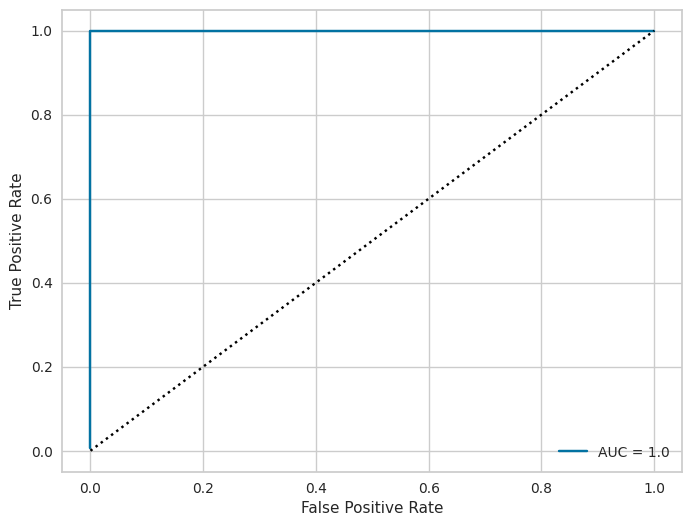

In [ ]:
plt.rcParams["figure.figsize"] = [8, 6]
rocCoordinates = modelPerformance.roc()
plt.plot(rocCoordinates[0], rocCoordinates[1], label = "AUC = " + str(modelPerformance.auc()))
plt.plot([0, 1], [0, 1], linestyle = "dotted", color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

##### Plot variable importance.

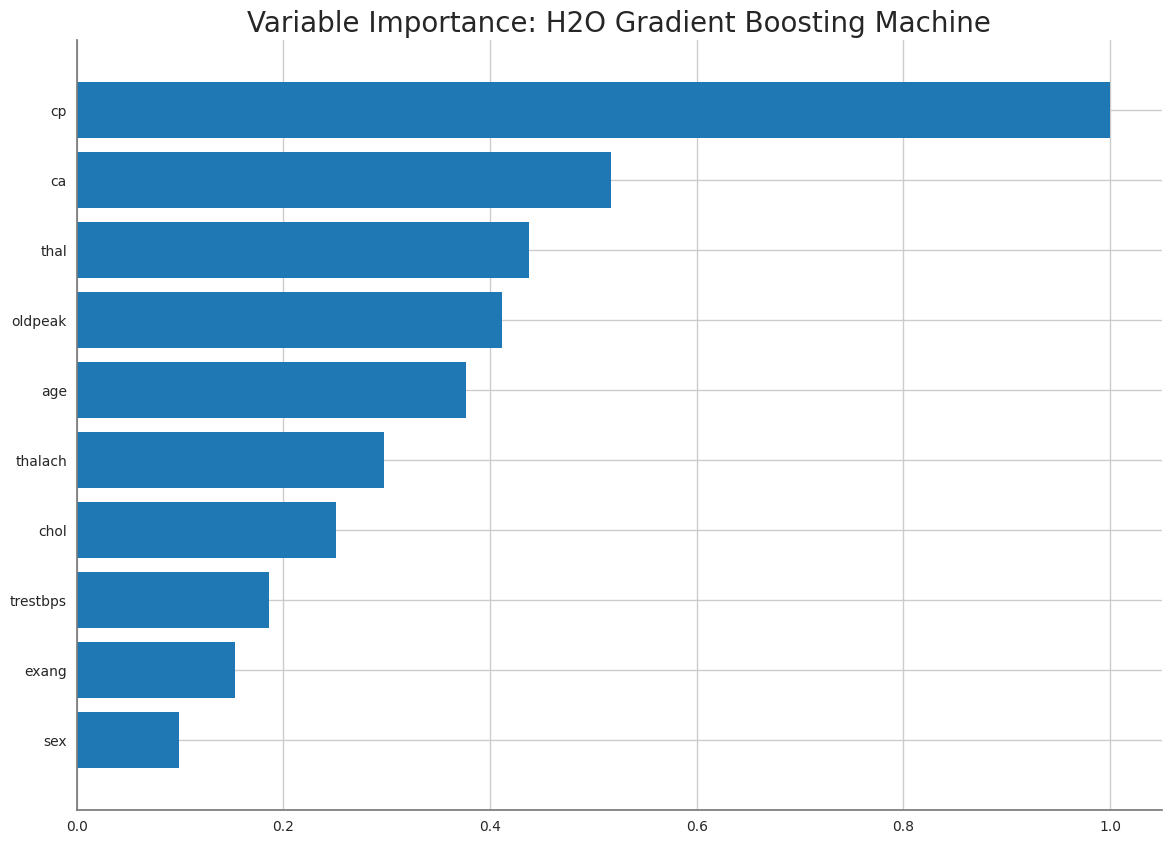

<Figure size 800x600 with 0 Axes>

In [ ]:
h2oAutomlBestModel.varimp_plot()
plt.show()

##### Save best model.

In [ ]:
h2oAutomlBestModel.save_mojo(path + "h2oAutomlBestModel.zip")

'/content/gdrive/MyDrive/Colab Notebooks/4_autoML/h2oAutomlBestModel.zip/GBM_3_AutoML_1_20231206_71205.zip'

##### Load best model.

In [ ]:
loadedH2oAutomlBestModel = h2o.import_mojo(path + "h2oAutomlBestModel.zip")

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Back to the list of [**section links**](#0)

$\hspace{1in}$

<a name="3"></a>
##### **PyCaret**

##### Initialize the training environment.

In [ ]:
trainingEnv = setup(trainSet, target = "target", index = False, test_data = testSet, ordinal_features = {"slope": [0, 1, 2], "ca": [0, 1, 2, 3, 4]},
                    numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"],  categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "thal"],
                    session_id = 1)

,Description,Value
0,Session id,1
1,Target,target
2,Target type,Binary
3,Original data shape,"(1328, 14)"
4,Transformed data shape,"(1328, 22)"
5,Transformed train set shape,"(1025, 22)"
6,Transformed test set shape,"(303, 22)"
7,Ordinal features,5
8,Numeric features,5
9,Categorical features,6


##### Note: PyCaret considers categorical features with only two classes as ordinal features too. This is why the output of the setup function indicates that there are 5 ordinal features when it was specified in the function call that there are 2 ordinal features, namely the *slope* and *ca* variables. The 3 additional ordinal features are the categorical features *sex*, *fbs*, and *exang*.

##### Train and compare models, and choose the best model.

In [ ]:
pyCaretBestModel = compare_models()
pyCaretBestModel

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9971,0.9970,1.0000,0.9945,0.9972,0.9941,0.9943,0.1490
rf,Random Forest Classifier,0.9971,1.0000,1.0000,0.9945,0.9972,0.9941,0.9943,0.5280
et,Extra Trees Classifier,0.9971,1.0000,1.0000,0.9945,0.9972,0.9941,0.9943,0.3370
xgboost,Extreme Gradient Boosting,0.9971,1.0000,1.0000,0.9945,0.9972,0.9941,0.9943,0.3570
lightgbm,Light Gradient Boosting Machine,0.9971,1.0000,1.0000,0.9945,0.9972,0.9941,0.9943,0.4800
catboost,CatBoost Classifier,0.9941,0.9994,1.0000,0.9892,0.9944,0.9883,0.9886,2.0880
gbc,Gradient Boosting Classifier,0.9766,0.9921,0.9774,0.9775,0.9771,0.9532,0.9539,0.3050
ada,Ada Boost Classifier,0.8946,0.9623,0.9049,0.8919,0.8977,0.7890,0.7904,0.3180
lr,Logistic Regression,0.8516,0.9203,0.8935,0.8320,0.8609,0.7025,0.7060,1.1130
ridge,Ridge Classifier,0.8438,0.0000,0.8972,0.8172,0.8548,0.6866,0.6914,0.1470


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=1, splitter='best')

##### Predict on test set.

In [ ]:
testSetPredictions = predict_model(pyCaretBestModel)
testSetPredictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,prediction_label,prediction_score
1025,63,1,3,145,233,1,0,150,0,2.3000,0,0,1,1,1,1.0000
1026,37,1,2,130,250,0,1,187,0,3.5000,0,0,2,1,1,1.0000
1027,41,0,1,130,204,0,0,172,0,1.4000,2,0,2,1,1,1.0000
1028,56,1,1,120,236,0,1,178,0,0.8000,2,0,2,1,1,1.0000
1029,57,0,0,120,354,0,1,163,1,0.6000,2,0,2,1,1,1.0000


##### Plot confusion matrix.

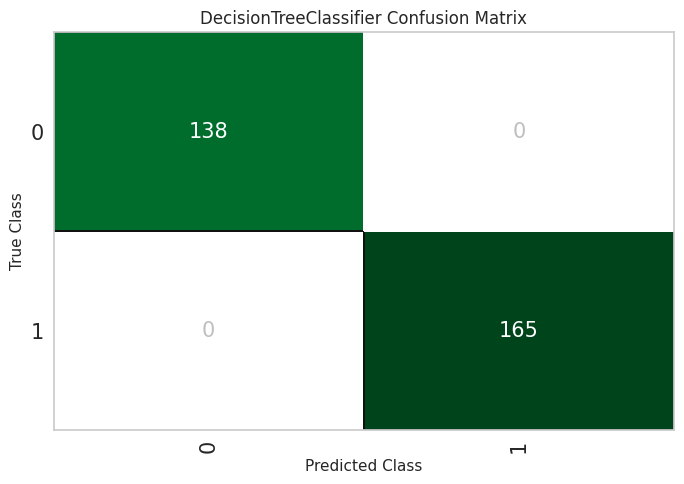

In [ ]:
plt.rcParams["figure.figsize"] = [7, 5]
plot_model(pyCaretBestModel, plot = "confusion_matrix")

##### Plot ROC curve.

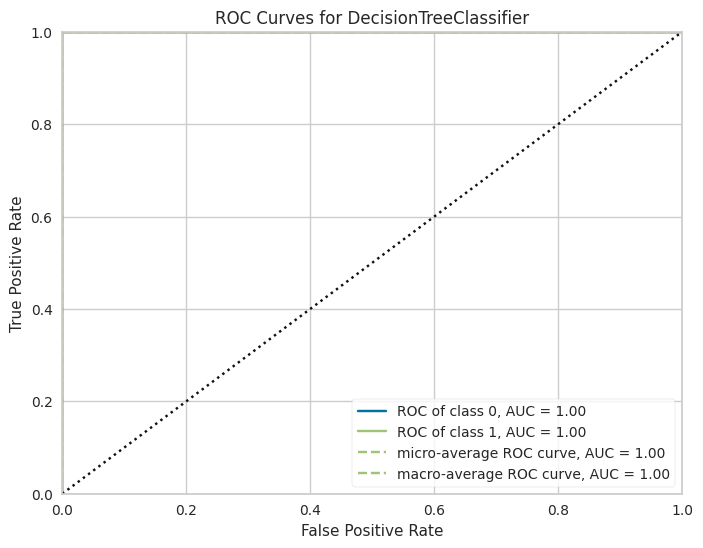

In [ ]:
plt.rcParams["figure.figsize"] = [8, 6]
plot_model(pyCaretBestModel, plot = "auc")

##### Plot feature importance.

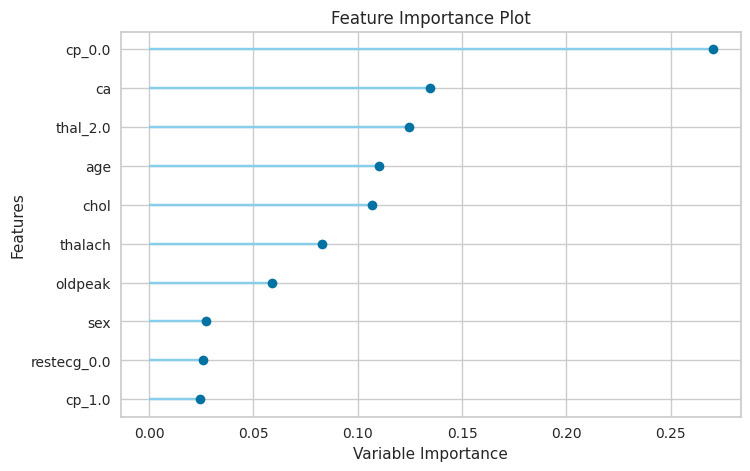

In [ ]:
plot_model(pyCaretBestModel, plot = "feature")

##### Save pipeline and best model.

In [ ]:
save_model(pyCaretBestModel, path + "pyCaretBestModel")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'trestbps', 'chol',
                                              'thalach', 'oldpeak'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper...
                                                               handl

##### Load pipeline and best model.

In [ ]:
loadedPyCaretBestModel = load_model(path + "pyCaretBestModel")
loadedPyCaretBestModel

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'trestbps', 'chol',
                                             'thalach', 'oldpeak'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('categorical_imputer',
                 Transfo...
                                                              handle_unknown='value',
                                                              return_df=True,
                                                              use_cat_names=True,
                                                              verbose=0))),
                ('trained_model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        random_state=1, splitter='best'))],
         verbose=False)

Back to the list of [**section links**](#0)

$\hspace{1in}$

<a name="4"></a>
##### **TPOT**

##### Build a one-hot encoding in the train and test sets of each of the nonbinary features that will be treated as categorical.

In [ ]:
oneHotEncodedTrainSet = pd.get_dummies(trainSet, columns = ["cp", "restecg", "thal"], drop_first = True)
oneHotEncodedTrainSet.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0000,2,2,0,0,0,0,1,0,0,0,1
1,53,1,140,203,1,155,1,3.1000,0,0,0,0,0,0,0,0,0,0,1
2,70,1,145,174,0,125,1,2.6000,0,0,0,0,0,0,1,0,0,0,1
3,61,1,148,203,0,161,0,0.0000,2,1,0,0,0,0,1,0,0,0,1
4,62,0,138,294,1,106,0,1.9000,1,3,0,0,0,0,1,0,0,1,0


In [ ]:
oneHotEncodedTestSet = pd.get_dummies(testSet, columns = ["cp", "restecg", "thal"], drop_first = True)
oneHotEncodedTestSet.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3000,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5000,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4000,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8000,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6000,2,0,1,0,0,0,1,0,0,1,0


##### Create models, fit them to the training set, and choose the best model.

In [ ]:
pipelineOptimizer = TPOTClassifier(generations = 20, population_size = 20, cv = 10, random_state = 1, verbosity = 2)

xTrain = oneHotEncodedTrainSet.drop(columns = ["target"])
yTrain = oneHotEncodedTrainSet["target"]
pipelineOptimizer.fit(xTrain, yTrain)

Optimization Progress:   0%|          | 0/420 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9941747572815534

Generation 2 - Current best internal CV score: 0.9941747572815534

Generation 3 - Current best internal CV score: 0.9941747572815534

Generation 4 - Current best internal CV score: 0.9970873786407767

Generation 5 - Current best internal CV score: 0.9970873786407767

Generation 6 - Current best internal CV score: 0.9970873786407767

Generation 7 - Current best internal CV score: 0.9970873786407767

Generation 8 - Current best internal CV score: 0.9970873786407767

Generation 9 - Current best internal CV score: 0.9970873786407767

Generation 10 - Current best internal CV score: 0.9970873786407767

Generation 11 - Current best internal CV score: 0.9970873786407767

Generation 12 - Current best internal CV score: 0.9970873786407767

Generation 13 - Current best internal CV score: 0.9970873786407767

Generation 14 - Current best internal CV score: 0.9970873786407767

Generation 15 - Current best internal CV score: 0.997087

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=10,
               disable_update_check=False, early_stop=None, generations=20,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=20,
               random_state=1, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

##### Display all the pipelines that were evaluated during the pipeline optimization process.

In [ ]:
evaluatedPipelines = pd.DataFrame(pipelineOptimizer.evaluated_individuals_).T
evaluatedPipelines

,generation,mutation_count,crossover_count,predecessor,operator_count,internal_cv_score
"DecisionTreeClassifier(RBFSampler(input_matrix, RBFSampler__gamma=0.4), DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=10, DecisionTreeClassifier__min_samples_leaf=12, DecisionTreeClassifier__min_samples_split=7)",0,0,0,"(ROOT,)",2,0.8605
"KNeighborsClassifier(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.01), KNeighborsClassifier__n_neighbors=15, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=distance)",0,0,0,"(ROOT,)",2,0.9941
"LinearSVC(input_matrix, LinearSVC__C=5.0, LinearSVC__dual=True, LinearSVC__loss=squared_hinge, LinearSVC__penalty=l2, LinearSVC__tol=0.0001)",0,0,0,"(ROOT,)",1,0.7654
"XGBClassifier(DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=2, DecisionTreeClassifier__min_samples_leaf=13, DecisionTreeClassifier__min_samples_split=8), XGBClassifier__learning_rate=0.5, XGBClassifier__max_depth=4, XGBClassifier__min_child_weight=13, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.9500000000000001, XGBClassifier__verbosity=0)",0,0,0,"(ROOT,)",2,0.9492
"LinearSVC(PCA(input_matrix, PCA__iterated_power=9, PCA__svd_solver=randomized), LinearSVC__C=10.0, LinearSVC__dual=True, LinearSVC__loss=squared_hinge, LinearSVC__penalty=l2, LinearSVC__tol=0.001)",0,0,0,"(ROOT,)",2,0.7198
...,...,...,...,...,...,...
"XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.5, XGBClassifier__max_depth=2, XGBClassifier__min_child_weight=10, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.6500000000000001, XGBClassifier__verbosity=0)",20,4,0,"(KNeighborsClassifier(input_matrix, KNeighbors...",1,0.9239
"GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=1.0, GradientBoostingClassifier__max_depth=10, GradientBoostingClassifier__max_features=0.55, GradientBoostingClassifier__min_samples_leaf=4, GradientBoostingClassifier__min_samples_split=7, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.7500000000000001)",20,2,0,"(GradientBoostingClassifier(input_matrix, Grad...",1,0.9941
"KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)",20,6,0,"(KNeighborsClassifier(input_matrix, KNeighbors...",1,0.7131
"MLPClassifier(input_matrix, MLPClassifier__alpha=0.001, MLPClassifier__learning_rate_init=1.0)",20,3,0,"(KNeighborsClassifier(input_matrix, KNeighbors...",1,0.5112


##### Display the best pipeline and model.

In [ ]:
tpotBestModel = pipelineOptimizer.fitted_pipeline_
tpotBestModel

Pipeline(memory=None,
         steps=[('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=15, p=2,
                                      weights='distance'))],
         verbose=False)

##### Predict on test set.

In [ ]:
xTest = oneHotEncodedTestSet.drop(columns = ["target"])
predictionLabels = tpotBestModel.predict(xTest)
predictionScores = tpotBestModel.predict_proba(xTest)[:, 1]

testSetPredictions = xTest.copy()
testSetPredictions["prediction_label"] = predictionLabels
testSetPredictions["prediction_score"] = predictionScores
testSetPredictions.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3,prediction_label,prediction_score
0,63,1,145,233,1,150,0,2.3000,0,0,0,0,1,0,0,1,0,0,1,1.0000
1,37,1,130,250,0,187,0,3.5000,0,0,0,1,0,1,0,0,1,0,1,1.0000
2,41,0,130,204,0,172,0,1.4000,2,0,1,0,0,0,0,0,1,0,1,1.0000
3,56,1,120,236,0,178,0,0.8000,2,0,1,0,0,1,0,0,1,0,1,1.0000
4,57,0,120,354,0,163,1,0.6000,2,0,0,0,0,1,0,0,1,0,1,1.0000


##### Plot confusion matrix.

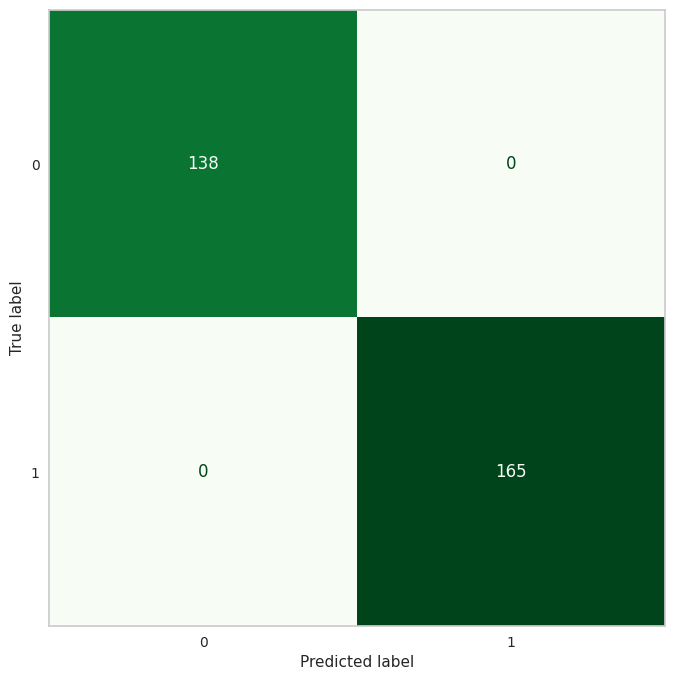

In [ ]:
yTest = oneHotEncodedTestSet["target"]
yPred = testSetPredictions["prediction_label"]
confusionMatrix = metrics.confusion_matrix(yTest, yPred)

plt.rcParams["figure.figsize"] = [12, 8]
display = metrics.ConfusionMatrixDisplay(confusionMatrix)
display.plot(cmap = plt.cm.Greens, colorbar = False)
plt.grid(None)
plt.show()

##### Plot ROC curve.

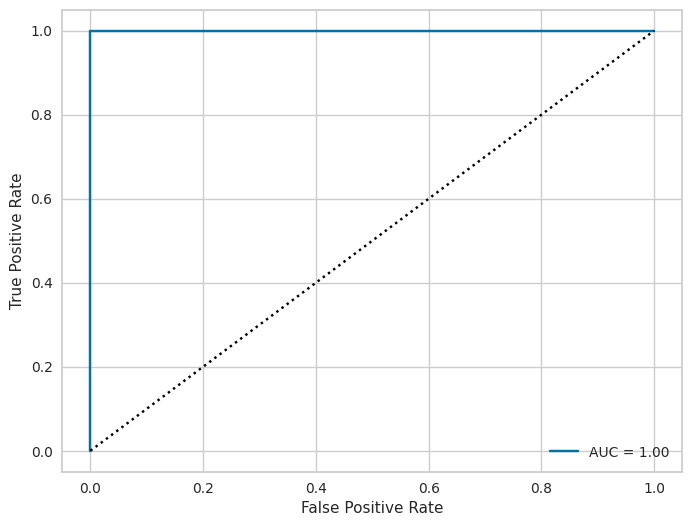

In [ ]:
plt.rcParams["figure.figsize"] = [8, 6]
fpr, tpr, thresholds = metrics.roc_curve(yTest, predictionScores)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
display.plot()
plt.plot([0, 1], [0, 1], linestyle = "dotted", color = "black")
plt.show()

##### Plot permutation importance of the features.

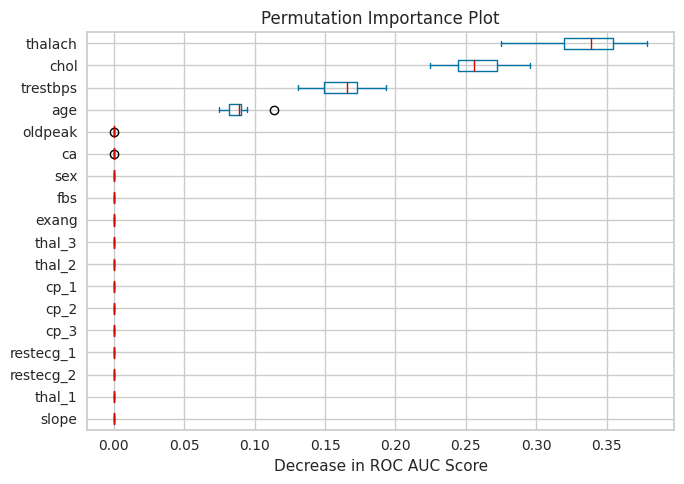

In [ ]:
result = permutation_importance(tpotBestModel, xTest, yTest, n_repeats = 10, random_state = 1, scoring = "roc_auc")
sortedIdx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sortedIdx].T, columns = xTest.columns[sortedIdx])

plt.rcParams["figure.figsize"] = [7, 5]
ax = importances.plot.box(vert = False)
ax.set_title("Permutation Importance Plot")
ax.set_xlabel("Decrease in ROC AUC Score")
ax.figure.tight_layout()

##### Save best pipeline and model.

In [ ]:
pickle.dump(tpotBestModel, open(path + "tpotBestModel.pkl", "wb"))

##### Load best pipeline and model.

In [ ]:
loadedTpotBestModel = pickle.load(open(path + "tpotBestModel.pkl", "rb"))

Back to the list of [**section links**](#0)